### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import os


In [3]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [4]:
# Try loading one file

df = pd.read_parquet('2023-1.parquet')
df.info()
print(f"Total Rows: {len(df)}")

<class 'pandas.core.frame.DataFrame'>
Index: 3041714 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [6]:
# 5% sampling of each hour's data
df_sample = pd.DataFrame()

for month in range(1, 13):
    file_name = f'2023-{month}.parquet'
    try:
        monthly_data = pd.read_parquet(file_name)
        
        # Extract date and hour from pickup datetime
        monthly_data['tpep_pickup_datetime'] = pd.to_datetime(monthly_data['tpep_pickup_datetime'])
        monthly_data['pickup_date'] = monthly_data['tpep_pickup_datetime'].dt.date
        monthly_data['pickup_hour'] = monthly_data['tpep_pickup_datetime'].dt.hour
        
        # 5% sampling from each hour of each date
        for date in monthly_data['pickup_date'].unique():
            for hour in range(24):
                hour_data = monthly_data[(monthly_data['pickup_date'] == date) & (monthly_data['pickup_hour'] == hour)]
                if len(hour_data) > 0:
                    sample = hour_data.sample(frac=0.05, random_state=42)
                    df_sample = pd.concat([df_sample, sample])
                    
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [8]:
df_sample.to_parquet('nyc_taxi_2023_sampled.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [9]:
# Load the new data file

df = pd.read_parquet('nyc_taxi_2023_sampled.parquet')

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour,Airport_fee
428,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,N,138,256,2,...,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0,NaN
1113,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,N,161,237,1,...,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0,NaN
819,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,N,237,141,2,...,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0,NaN
3192,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,N,143,142,2,...,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0,NaN
2995263,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,None,66,107,0,...,0.5,5.93,0.0,1.0,35.57,NaN,NaN,2023-01-01,0,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1896400 entries, 428 to 3196303
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            fl

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [12]:
# Fix the index and drop any columns that are not needed
df = df.drop(columns=['store_and_fwd_flag'])  # Not useful for analysis
df = df.reset_index(drop=True)



**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [13]:
# Combine the two airport fee columns if both exist
if 'Airport_fee' in df.columns and 'airport_fee' in df.columns:
	df['airport_fee'] = df['airport_fee'].fillna(df['Airport_fee'])
	df = df.drop(columns=['Airport_fee'])


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [15]:
# check where values of fare amount are negative
df[df['total_amount'] < 0].head(10)

        


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
3966,2,2023-01-02 05:12:19,2023-01-02 05:41:45,1.0,17.07,3.0,142,1,2,0.0,0.0,0.0,0.0,0.0,-1.0,-1.00,0.0,0.00,2023-01-02,5
9093,2,2023-01-03 14:24:45,2023-01-03 14:25:14,1.0,0.00,2.0,132,132,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-5.25,-2.5,-1.25,2023-01-03,14
77200,2,2023-01-17 12:37:35,2023-01-17 13:24:00,1.0,17.68,2.0,230,132,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.00,-2.5,0.00,2023-01-17,12
77920,2,2023-01-17 15:03:44,2023-01-17 15:36:28,1.0,4.12,1.0,239,168,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.00,-2.5,0.00,2023-01-17,15
86509,2,2023-01-19 09:50:26,2023-01-19 09:58:13,1.0,0.50,1.0,161,43,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.00,-2.5,0.00,2023-01-19,9
117837,2,2023-01-25 11:10:37,2023-01-25 11:11:02,1.0,0.02,2.0,170,233,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.00,-2.5,0.00,2023-01-25,11
120029,2,2023-01-25 18:52:24,2023-01-25 19:06:34,1.0,1.75,1.0,140,163,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.00,-2.5,0.00,2023-01-25,18
171987,2,2023-03-08 15:51:33,2023-03-08 15:52:12,1.0,0.00,1.0,231,231,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-1.50,0.0,0.00,2023-03-08,15
186660,2,2023-03-05 00:50:17,2023-03-05 00:50:38,1.0,0.00,2.0,70,70,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-1.50,0.0,0.00,2023-03-05,0
205199,2,2023-03-10 16:18:09,2023-03-10 16:49:43,3.0,6.94,1.0,88,230,2,0.0,0.0,-0.5,0.0,0.0,-1.0,-4.00,-2.5,0.00,2023-03-10,16


Did you notice something different in the `RatecodeID` column for above records?

In [16]:
# Analyse RatecodeID for the negative total amounts
df['RatecodeID'].value_counts()


RatecodeID
1.0     1729259
2.0       71670
99.0      10472
5.0       10275
3.0        6124
4.0        3723
6.0           3
Name: count, dtype: int64

In [17]:
# Find which columns have negative values (only numeric columns)
numeric_cols = df.select_dtypes(include=['number']).columns
negative_columns = [col for col in numeric_cols if (df[col] < 0).any()]
print("Columns with negative values:", negative_columns)




Columns with negative values: ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']


In [18]:
# fix these negative values
for col in negative_columns:
    df[col] = df[col].clip(lower=0)  # Set negative values to 0
# Check if there are any negative values left
for col in negative_columns:
    if (df[col] < 0).any():
        print(f"Negative values still present in {col}")
    else:
        print(f"No negative values in {col} after fixing")




No negative values in extra after fixing
No negative values in mta_tax after fixing
No negative values in improvement_surcharge after fixing
No negative values in total_amount after fixing
No negative values in congestion_surcharge after fixing
No negative values in airport_fee after fixing


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [19]:
# Find the proportion of missing values in each column
missing_values = df.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing values in each column (%):")
print(missing_values)



Missing values in each column (%):
passenger_count         3.420903
RatecodeID              3.420903
congestion_surcharge    3.420903
airport_fee             3.420903
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [20]:
# Display the rows with null values
missing_rows = df[df.isnull().any(axis=1)]
print("Rows with missing values:")

# Impute NaN values in 'passenger_count'
df['passenger_count'] = df['passenger_count'].fillna(1)
df = df[df['passenger_count'] > 0]
df

Rows with missing values:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,1.0,19.24,NaN,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,NaN,NaN,2023-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896395,2,2023-12-31 23:44:09,2023-12-31 23:50:04,1.0,0.81,1.0,263,262,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896396,2,2023-12-31 23:44:04,2024-01-01 00:03:36,1.0,5.78,1.0,161,261,1,27.50,1.0,0.5,4.00,0.0,1.0,36.50,2.5,0.00,2023-12-31,23
1896397,2,2023-12-31 23:37:20,2023-12-31 23:41:18,1.0,1.06,1.0,79,137,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896398,1,2023-12-31 23:12:30,2023-12-31 23:21:12,1.0,0.00,NaN,166,244,0,14.64,0.0,0.5,0.00,0.0,1.0,16.14,NaN,NaN,2023-12-31,23


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [21]:
# Fix missing values in 'RatecodeID'
df['RatecodeID'] = df['RatecodeID'].fillna(1)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,1.0,19.24,1.0,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,NaN,NaN,2023-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896395,2,2023-12-31 23:44:09,2023-12-31 23:50:04,1.0,0.81,1.0,263,262,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896396,2,2023-12-31 23:44:04,2024-01-01 00:03:36,1.0,5.78,1.0,161,261,1,27.50,1.0,0.5,4.00,0.0,1.0,36.50,2.5,0.00,2023-12-31,23
1896397,2,2023-12-31 23:37:20,2023-12-31 23:41:18,1.0,1.06,1.0,79,137,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896398,1,2023-12-31 23:12:30,2023-12-31 23:21:12,1.0,0.00,1.0,166,244,0,14.64,0.0,0.5,0.00,0.0,1.0,16.14,NaN,NaN,2023-12-31,23


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [22]:
# handle null values in congestion_surcharge
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(1)
df


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,1.0,19.24,1.0,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,1.0,NaN,2023-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896395,2,2023-12-31 23:44:09,2023-12-31 23:50:04,1.0,0.81,1.0,263,262,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896396,2,2023-12-31 23:44:04,2024-01-01 00:03:36,1.0,5.78,1.0,161,261,1,27.50,1.0,0.5,4.00,0.0,1.0,36.50,2.5,0.00,2023-12-31,23
1896397,2,2023-12-31 23:37:20,2023-12-31 23:41:18,1.0,1.06,1.0,79,137,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896398,1,2023-12-31 23:12:30,2023-12-31 23:21:12,1.0,0.00,1.0,166,244,0,14.64,0.0,0.5,0.00,0.0,1.0,16.14,1.0,NaN,2023-12-31,23


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [23]:
# Handle any remaining missing values
missing_values = df.isna().sum()
missing_values

# Found out 26706 missing values in airport_fee
if 'airport_fee' in df.columns:
    df['airport_fee'] = df['airport_fee'].fillna(0)
    
missing_values

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID                   0
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge         0
airport_fee              64874
pickup_date                  0
pickup_hour                  0
dtype: int64

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [24]:
# Describe the data and check if there are any potential outliers present
df.describe()

# Check for potential out of place values in various columns
numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'passenger_count']

# Calculate summary statistics
outliers = df[numeric_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
print("Statistical Summary (showing extremes):")
display(outliers)

Statistical Summary (showing extremes):


,trip_distance,fare_amount,tip_amount,tolls_amount,total_amount,passenger_count
count,1.866719e+06,1.866719e+06,1.866719e+06,1.866719e+06,1.866719e+06,1.866719e+06
mean,3.875073e+00,1.996151e+01,3.555185e+00,5.997746e-01,2.903783e+01,1.378154e+00
std,1.304323e+02,1.063526e+02,4.056978e+00,2.193071e+00,1.072285e+02,8.699633e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
1%,0.000000e+00,4.400000e+00,0.000000e+00,0.000000e+00,8.700000e+00,1.000000e+00
5%,4.600000e-01,5.800000e+00,0.000000e+00,0.000000e+00,1.150000e+01,1.000000e+00
25%,1.050000e+00,9.300000e+00,1.000000e+00,0.000000e+00,1.596000e+01,1.000000e+00
50%,1.800000e+00,1.350000e+01,2.850000e+00,0.000000e+00,2.107000e+01,1.000000e+00
75%,3.410000e+00,2.228000e+01,4.450000e+00,0.000000e+00,3.100000e+01,1.000000e+00
95%,1.536000e+01,7.000000e+01,1.200000e+01,6.550000e+00,8.269000e+01,3.000000e+00


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [25]:
# remove passenger_count > 6

df = df[df['passenger_count'] <= 6]
df



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,1.0,19.24,1.0,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,1.0,0.00,2023-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896395,2,2023-12-31 23:44:09,2023-12-31 23:50:04,1.0,0.81,1.0,263,262,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896396,2,2023-12-31 23:44:04,2024-01-01 00:03:36,1.0,5.78,1.0,161,261,1,27.50,1.0,0.5,4.00,0.0,1.0,36.50,2.5,0.00,2023-12-31,23
1896397,2,2023-12-31 23:37:20,2023-12-31 23:41:18,1.0,1.06,1.0,79,137,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896398,1,2023-12-31 23:12:30,2023-12-31 23:21:12,1.0,0.00,1.0,166,244,0,14.64,0.0,0.5,0.00,0.0,1.0,16.14,1.0,0.00,2023-12-31,23


In [26]:
# Continue with outlier handling

# Remove unrealistic trip distances
df = df[(df['trip_distance'] <= 250) & (df['trip_distance'] > 0)]

# Remove trips with 0 fare but different pickup/dropoff locations
same_zone = df['PULocationID'] == df['DOLocationID']
df = df[~((df['fare_amount'] == 0) & (~same_zone))]

# Remove invalid payment types
valid_payments = [1, 2, 3, 4]
df = df[df['payment_type'].isin(valid_payments)]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,138,256,2,32.4,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,2023-01-01,0
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.9,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,237,141,2,11.4,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,2023-01-01,0
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,143,142,2,6.5,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023-01-01,0
5,1,2023-01-01 00:42:56,2023-01-01 01:16:33,2.0,7.10,1.0,246,37,1,34.5,3.5,0.5,7.90,0.0,1.0,47.40,2.5,0.00,2023-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896394,2,2023-12-31 23:38:35,2024-01-01 00:05:50,5.0,9.29,1.0,48,25,1,41.5,1.0,0.5,9.30,0.0,1.0,55.80,2.5,0.00,2023-12-31,23
1896395,2,2023-12-31 23:44:09,2023-12-31 23:50:04,1.0,0.81,1.0,263,262,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23
1896396,2,2023-12-31 23:44:04,2024-01-01 00:03:36,1.0,5.78,1.0,161,261,1,27.5,1.0,0.5,4.00,0.0,1.0,36.50,2.5,0.00,2023-12-31,23
1896397,2,2023-12-31 23:37:20,2023-12-31 23:41:18,1.0,1.06,1.0,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00,2023-12-31,23


In [27]:
# Do any columns need standardising?
# Check the unique values in the RatecodeID column
print(df['RatecodeID'].unique())





[ 1.  2.  4.  5. 99.  3.  6.]


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [28]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'pickup_date',
 'pickup_hour']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

Text(0, 0.5, 'Number of Trips')

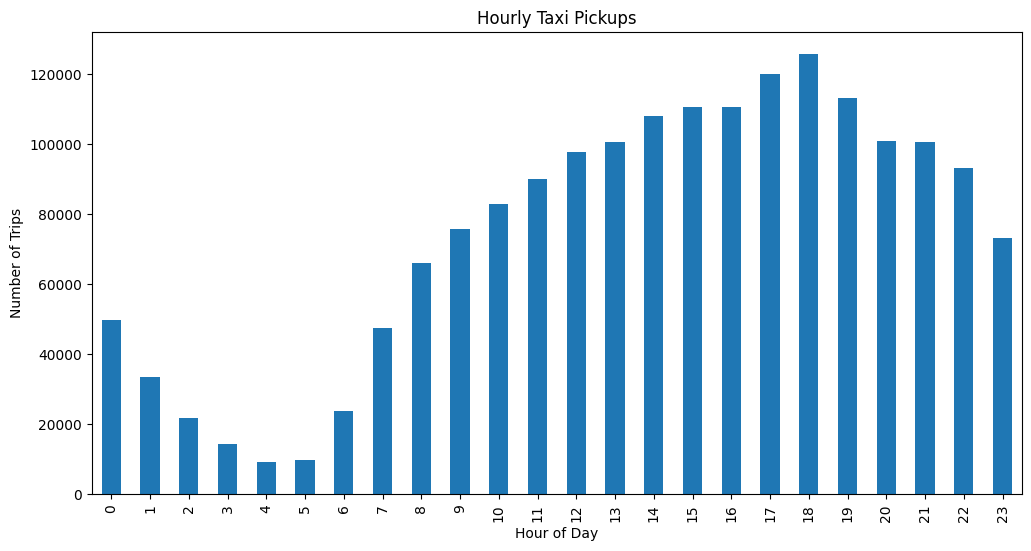

In [29]:
# Find and show the hourly trends in taxi pickups
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
hourly_counts = df.groupby('pickup_hour').size()
hourly_counts.plot(kind='bar', figsize=(12,6))
plt.title('Hourly Taxi Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')



Text(0, 0.5, 'Number of Trips')

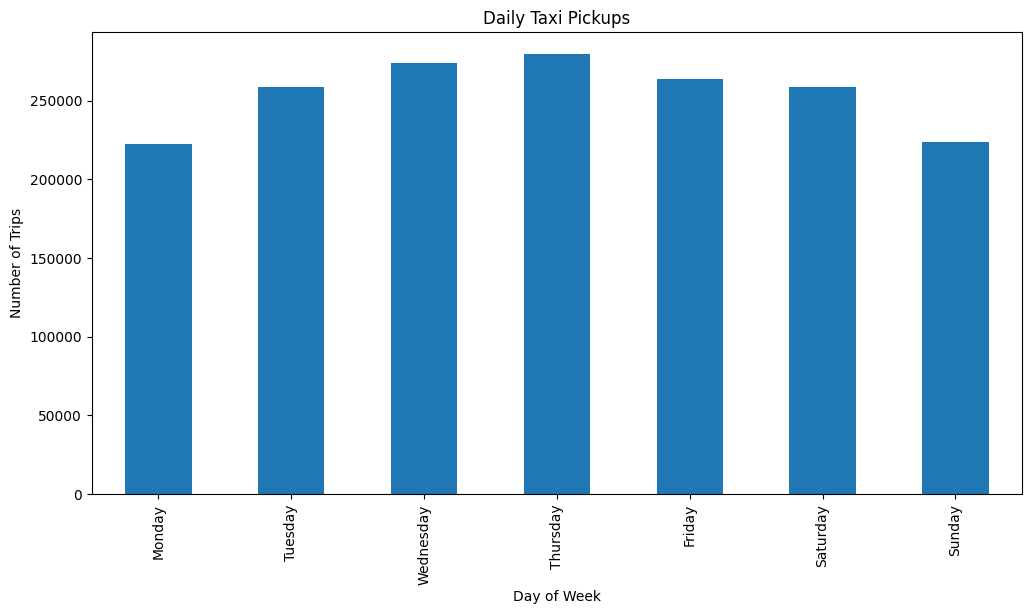

In [30]:
# Find and show the daily trends in taxi pickups (days of the week)

df['day_of_week'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
daily_counts = df.groupby('day_of_week').size()
daily_counts = daily_counts.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
daily_counts.plot(kind='bar', figsize=(12,6))
plt.title('Daily Taxi Pickups')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')



Text(0, 0.5, 'Number of Trips')

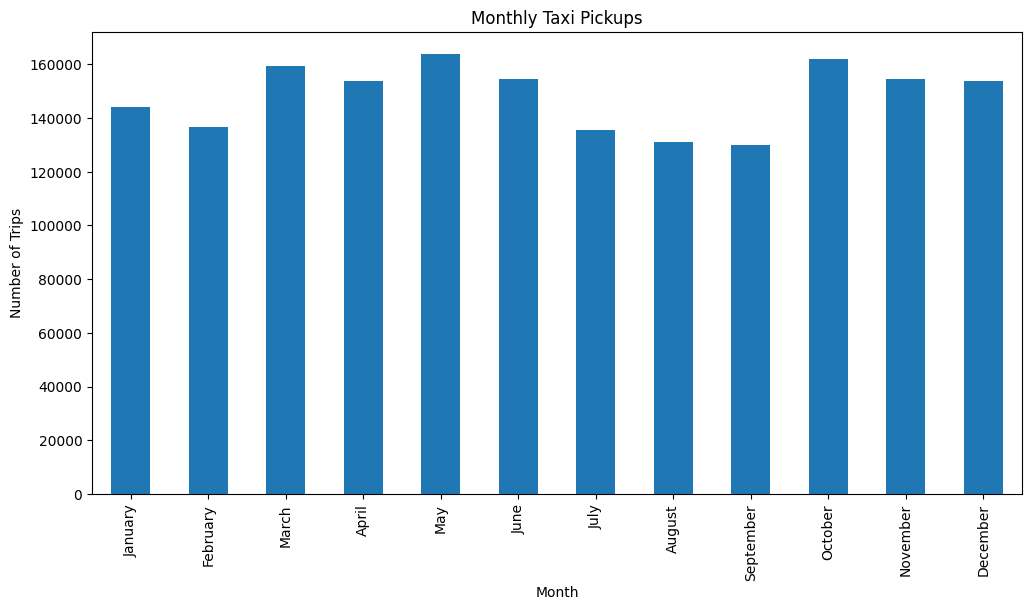

In [31]:
# Show the monthly trends in pickups
df['month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month_name()
monthly_counts = df.groupby('month').size()
monthly_counts = monthly_counts.reindex(['January','February','March','April','May','June',
                                       'July','August','September','October','November','December'])
monthly_counts.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Number of Trips')



##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [32]:
# Analyse the above parameters
financial_cols = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']
zero_negative_summary = {}

for col in financial_cols:
    zero_count = (df[col] == 0).sum()
    negative_count = (df[col] < 0).sum()
    zero_negative_summary[col] = {'zero_count': zero_count, 'negative_count': negative_count}

pd.DataFrame(zero_negative_summary)



,fare_amount,tip_amount,total_amount,trip_distance
zero_count,109,388216,38,0
negative_count,0,0,0,0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [33]:
# Create a df with non zero entries for the selected parameters.
df_nonzero = df[
    (df['fare_amount'] != 0) &
    (df['tip_amount'] != 0) &
    (df['total_amount'] != 0) &
    (df['trip_distance'] != 0)
]
df_nonzero.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date,pickup_hour,day_of_week,month
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.9,...,2.58,0.0,1.0,15.48,2.5,0.00,2023-01-01,0,Sunday,January
5,1,2023-01-01 00:42:56,2023-01-01 01:16:33,2.0,7.10,1.0,246,37,1,34.5,...,7.90,0.0,1.0,47.40,2.5,0.00,2023-01-01,0,Sunday,January
6,2,2023-01-01 00:58:00,2023-01-01 01:08:31,2.0,1.59,1.0,79,164,1,11.4,...,3.28,0.0,1.0,19.68,2.5,0.00,2023-01-01,0,Sunday,January
7,2,2023-01-01 00:16:06,2023-01-01 00:31:59,1.0,3.16,1.0,79,256,1,19.1,...,6.02,0.0,1.0,30.12,2.5,0.00,2023-01-01,0,Sunday,January
8,2,2023-01-01 00:44:09,2023-01-01 01:01:17,1.0,7.64,1.0,132,95,1,31.7,...,7.09,0.0,1.0,42.54,0.0,1.25,2023-01-01,0,Sunday,January


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

Text(0, 0.5, 'Total Revenue ($)')

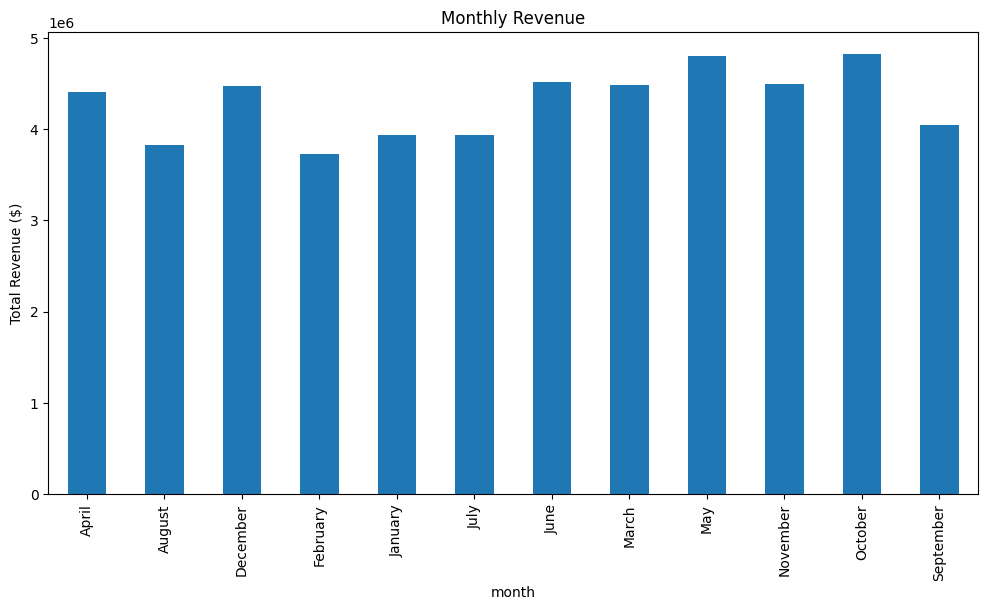

In [34]:
# Group data by month and analyse monthly revenue
monthly_revenue = df.groupby('month')['total_amount'].sum()
monthly_revenue.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Revenue')
plt.ylabel('Total Revenue ($)')


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

Text(0.5, 1.0, 'Revenue by Quarter')

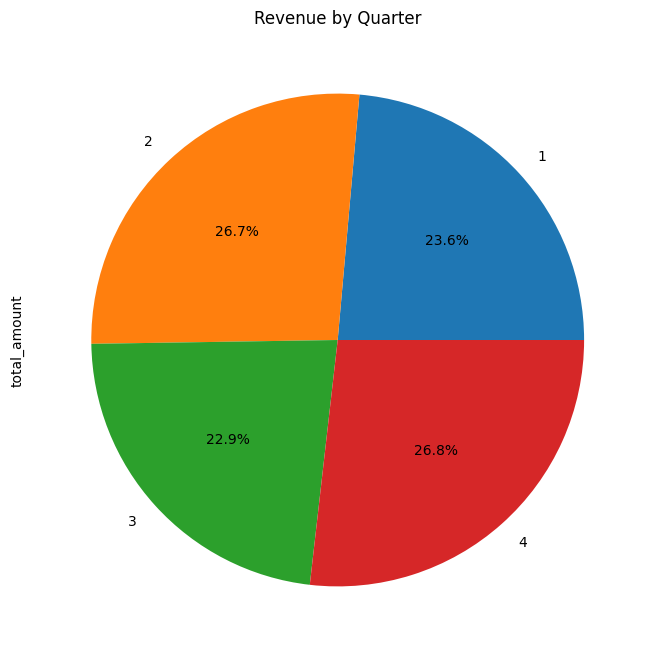

In [35]:
# Calculate proportion of each quarter

df['quarter'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.quarter
quarterly_revenue = df.groupby('quarter')['total_amount'].sum()
quarterly_revenue.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8))
plt.title('Revenue by Quarter')

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

In [36]:
# Show how trip fare is affected by distance


**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Text(0, 0.5, 'Fare Amount')

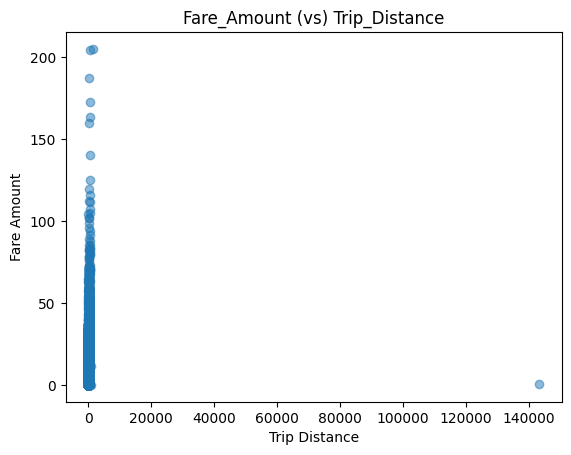

In [37]:
# Show relationship between fare and trip duration
plt.scatter(df['fare_amount'],df['trip_distance'], alpha=0.5)
plt.title('Fare_Amount (vs) Trip_Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')


Text(0, 0.5, 'Fare Amount')

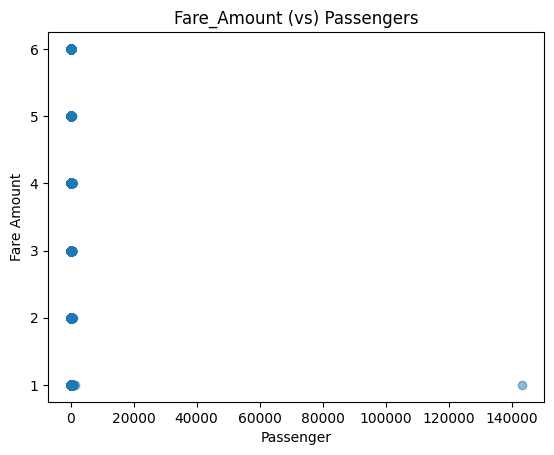

In [38]:
# Show relationship between fare and number of passengers
plt.scatter(df['fare_amount'],df['passenger_count'], alpha=0.5)
plt.title('Fare_Amount (vs) Passengers')
plt.xlabel('Passenger')
plt.ylabel('Fare Amount')


Text(0, 0.5, 'Tip Amount')

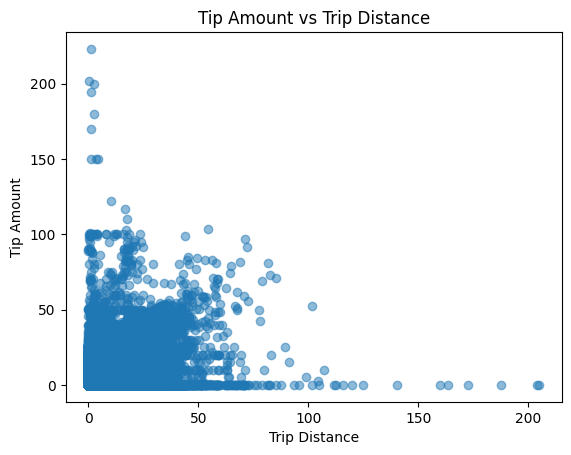

In [39]:
# Show relationship between tip and trip distance
plt.scatter(df['trip_distance'],df['tip_amount'], alpha=0.5)
plt.title('Tip Amount vs Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')


**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

Text(0, 0.5, 'Count')

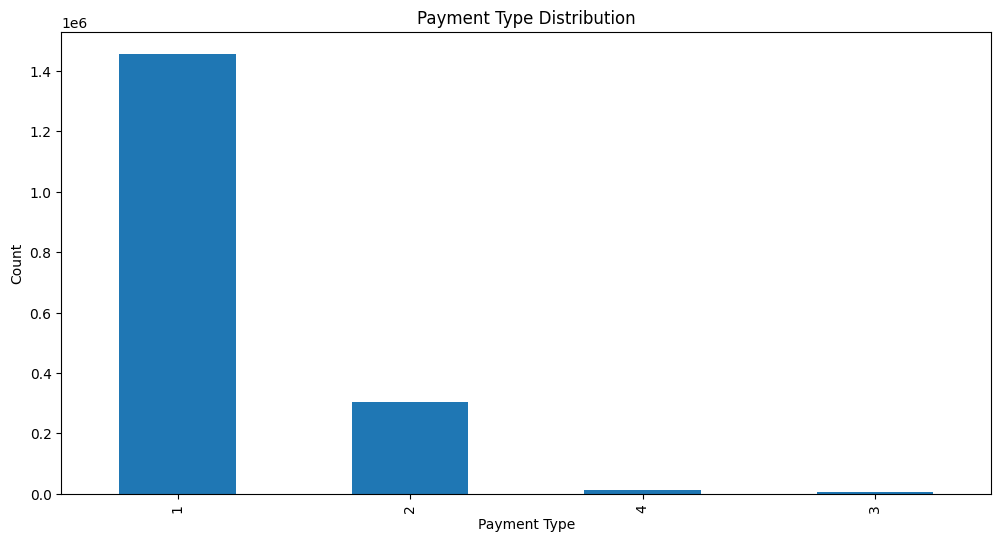

In [40]:
# Analyse the distribution of different payment types (payment_type).
payment_counts = df['payment_type'].value_counts()
payment_counts.plot(kind='bar', figsize=(12,6))
plt.title('Payment Type Distribution')
plt.xlabel('Payment Type')
plt.ylabel('Count')





- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [42]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [41]:
import geopandas as gpd

# Read the shapefile using geopandas
zones = gpd.read_file("taxi_zones.shp")
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

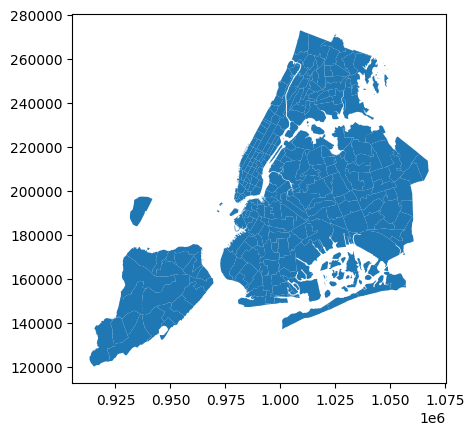

In [42]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [43]:
# Merge zones and trip records using locationID and PULocationID
pickup_counts = df.groupby('PULocationID').size().reset_index(name='pickup_count')
zones_with_trips = zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID')



**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [44]:
# Group data by location and calculate the number of trips
pickup_counts = df.groupby('PULocationID').size().reset_index(name='pickup_count')
pickup_counts


,PULocationID,pickup_count
0,1,47
1,2,2
2,3,31
3,4,1776
4,5,9
...,...,...
249,261,9371
250,262,23126
251,263,34097
252,264,15724


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [45]:
# Merge trip counts back to the zones GeoDataFrame
zones_with_trips = zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID', how='left')
zones_with_trips


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,pickup_count
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",1.0,47.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",2.0,2.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0,31.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4.0,1776.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",5.0,9.0
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",259.0,35.0
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",260.0,299.0
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261.0,9371.0
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",262.0,23126.0


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

Text(0.5, 1.0, 'Taxi Pickups by Zone')

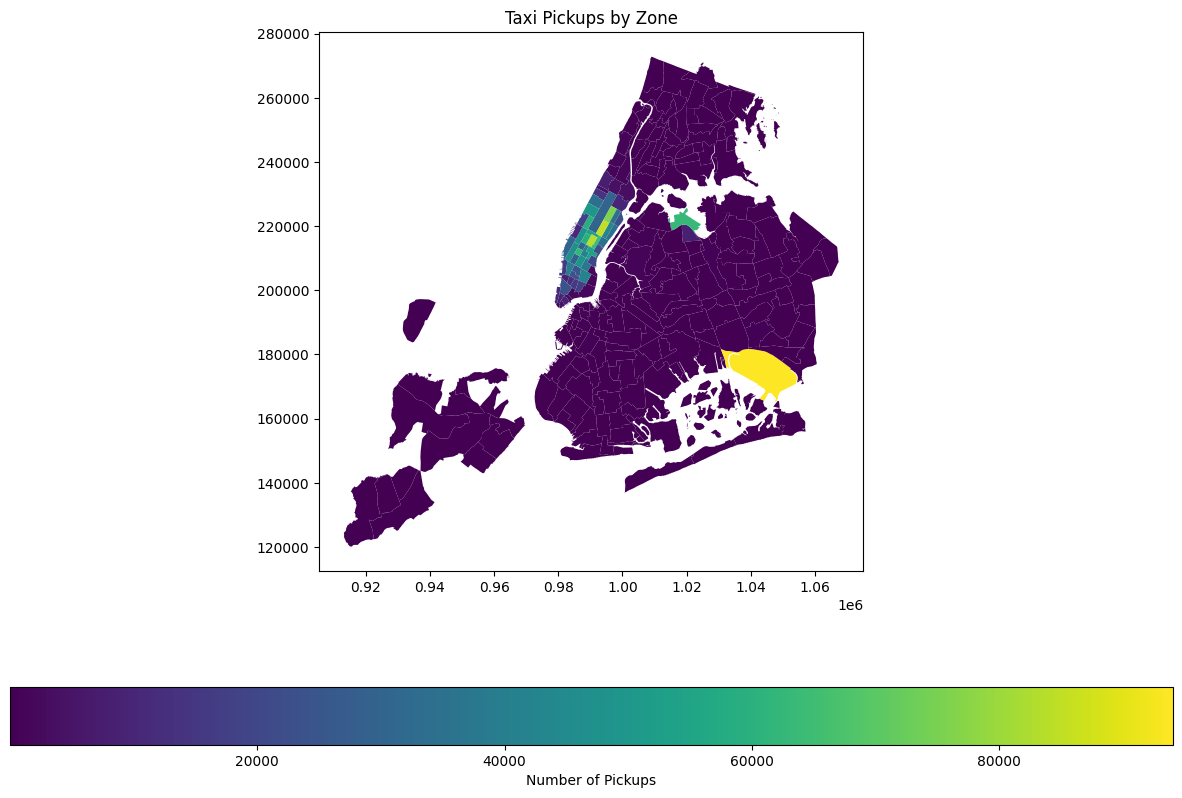

In [46]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
zones_with_trips.plot(column='pickup_count', ax=ax, legend=True,
                     legend_kwds={'label': "Number of Pickups", 'orientation': "horizontal"})
plt.title('Taxi Pickups by Zone')



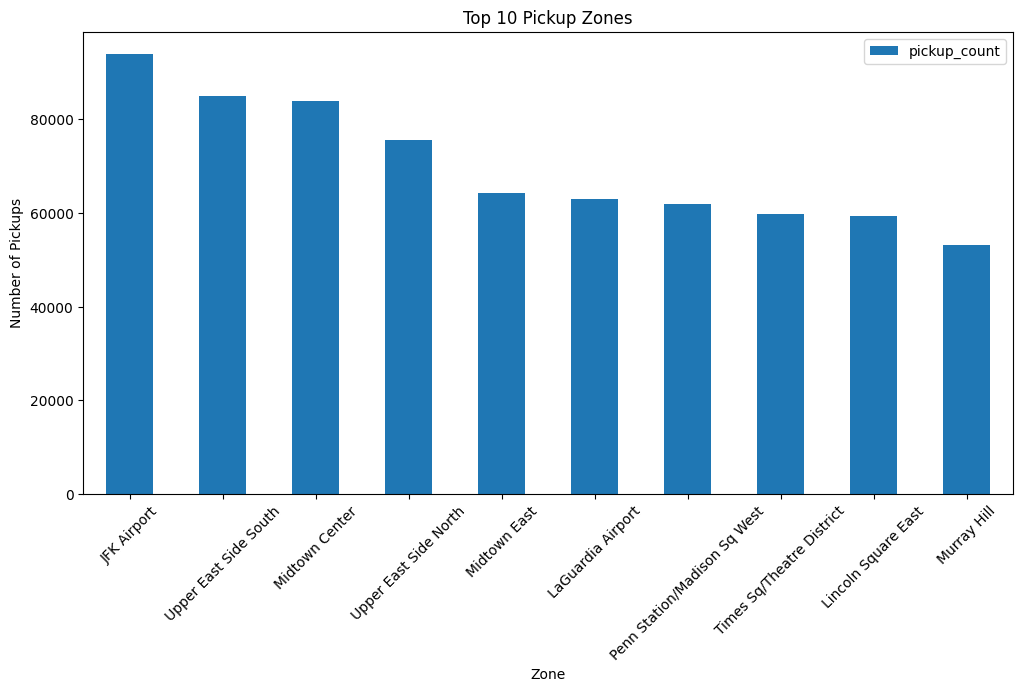

In [47]:
# can you try displaying the zones DF sorted by the number of trips?
zones_with_trips = zones_with_trips.sort_values(by='pickup_count', ascending=False)
zones_with_trips.head(10)
# Show the top 10 zones with the most pickups
top_zones = zones_with_trips.head(10)
top_zones[['zone', 'pickup_count']].plot(kind='bar', x='zone', y='pickup_count', figsize=(12,6))
plt.title('Top 10 Pickup Zones')
plt.xlabel('Zone')
plt.ylabel('Number of Pickups')
plt.xticks(rotation=45)
plt.show()


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

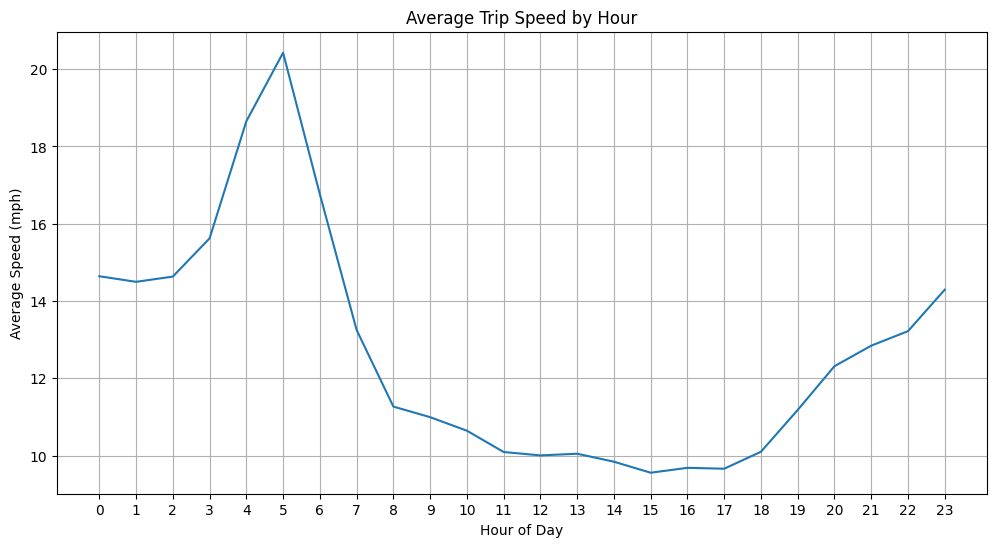

In [48]:
# Find routes which have the slowest speeds at different times of the day   
# Create a new column for trip speed
df['trip_speed'] = df['trip_distance'] / (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() * 3600   
# Filter out unrealistic speeds
df = df[(df['trip_speed'] > 0) & (df['trip_speed'] < 100)]
# Create a new column for pickup hour
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
# Group by pickup hour and calculate average speed
hourly_speed = df.groupby('pickup_hour')['trip_speed'].mean().reset_index()
# Plot the average speed by hour
plt.figure(figsize=(12, 6))
plt.plot(hourly_speed['pickup_hour'], hourly_speed['trip_speed'])
plt.title('Average Trip Speed by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed (mph)')
plt.xticks(hourly_speed['pickup_hour'])
plt.grid()
plt.show()


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

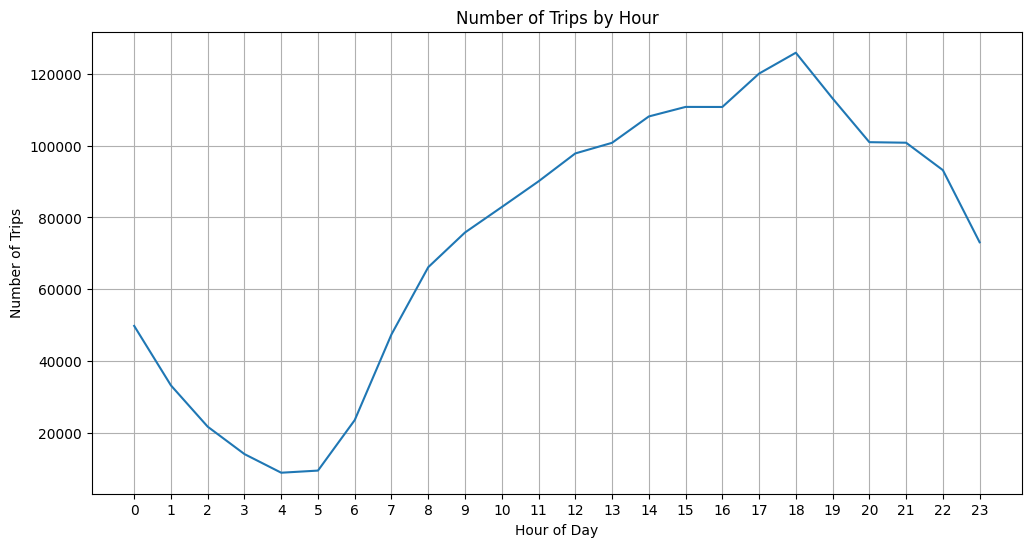

Busiest hour: 18 with 125808 trips
Slowest hour: 15 with average speed of 9.55 mph
Slowest route: 230 to 132 with speed of 9.55 mph


In [ ]:
# Visualise the number of trips per hour and find the busiest hour
hourly_counts = df['pickup_hour'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts.index, hourly_counts.values)
plt.title('Number of Trips by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(hourly_counts.index)
plt.grid()
plt.show()
# Find the busiest hour
busiest_hour = hourly_counts.idxmax()
busiest_hour_count = hourly_counts.max()
print(f"Busiest hour: {busiest_hour} with {busiest_hour_count} trips")
# Find the slowest hour
slowest_hour = hourly_speed.loc[hourly_speed['trip_speed'].idxmin(), 'pickup_hour']
slowest_hour_speed = hourly_speed['trip_speed'].min()
print(f"Slowest hour: {slowest_hour} with average speed of {slowest_hour_speed:.2f} mph")
# Find the slowest route
slowest_route = df.loc[df['trip_speed'].idxmin(), ['PULocationID', 'DOLocationID']]
print(f"Slowest route: {slowest_route['PULocationID']} to {slowest_route['DOLocationID']} with speed of {slowest_hour_speed:.2f} mph")
# Save the cleaned and processed data
df.to_parquet('nyc_taxi_2023_cleaned.parquet')



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [51]:
top5_hours_scaled = (top5_hours / sample_fraction).round().astype(int)

print("Five busiest hours (hour: scaled up trip count):")
print(top5_hours_scaled)

NameError: name 'top5_hours' is not defined

**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

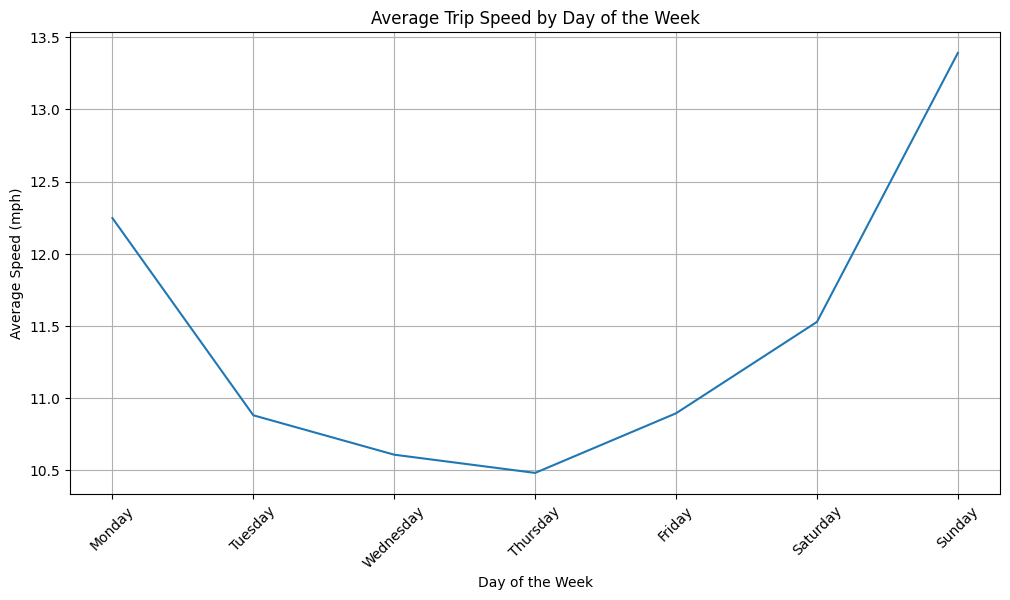

Busiest day: Thursday with 279300 trips
Slowest day: Thursday with average speed of 10.48 mph
Slowest route on busiest day: 161 to 132 with speed of 10.48 mph


In [52]:
# Compare traffic trends for the week days and weekends
# Create a new column for day of the week
df['day_of_week'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
# Group by day of the week and calculate average speed
weekly_speed = df.groupby('day_of_week')['trip_speed'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Plot the average speed by day of the week
plt.figure(figsize=(12, 6))
plt.plot(weekly_speed.index, weekly_speed.values)
plt.title('Average Trip Speed by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Speed (mph)')
plt.xticks(rotation=45)
plt.grid()
plt.show()
# Find the busiest day of the week
busiest_day = df['day_of_week'].value_counts().idxmax()
busiest_day_count = df['day_of_week'].value_counts().max()
print(f"Busiest day: {busiest_day} with {busiest_day_count} trips")
# Find the slowest day of the week
slowest_day = weekly_speed.idxmin()
slowest_day_speed = weekly_speed.min()
print(f"Slowest day: {slowest_day} with average speed of {slowest_day_speed:.2f} mph")
# Find the slowest route on the busiest day
busiest_day_data = df[df['day_of_week'] == busiest_day]
slowest_route_busiest_day = busiest_day_data.loc[busiest_day_data['trip_speed'].idxmin(), ['PULocationID', 'DOLocationID']]
print(f"Slowest route on busiest day: {slowest_route_busiest_day['PULocationID']} to {slowest_route_busiest_day['DOLocationID']} with speed of {slowest_day_speed:.2f} mph")
# Save the cleaned and processed data
df.to_parquet('nyc_taxi_2023_cleaned.parquet')




What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [53]:
# Find top 10 pickup and dropoff zones

# Find the most common pickup and dropoff zones
most_common_zones = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')
most_common_zones = most_common_zones.sort_values(by='count', ascending=False).head(10)
print("Most Common Pickup and Dropoff Zones:")
print(most_common_zones)




Most Common Pickup and Dropoff Zones:
       PULocationID  DOLocationID  count
18707           264           264  12445
16476           237           236  12352
16277           236           237  10652
16477           237           237   8277
16276           236           236   8006
10966           161           237   5927
16418           237           161   5671
10965           161           236   5015
9417            142           239   4857
8163            132           230   4522


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [59]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
pickup_dropoff_ratio = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')
pickup_dropoff_ratio['ratio'] = pickup_dropoff_ratio['count'] / pickup_dropoff_ratio['count'].sum()
pickup_dropoff_ratio = pickup_dropoff_ratio.sort_values(by='ratio', ascending=False)
top_10_ratio = pickup_dropoff_ratio.head(10)
bottom_10_ratio = pickup_dropoff_ratio.tail(10)
print("Top 10 Pickup/Dropoff Ratios:")
print(top_10_ratio)
print("Bottom 10 Pickup/Dropoff Ratios:")
print(bottom_10_ratio)



Top 10 Pickup/Dropoff Ratios:
      PULocationID  DOLocationID  count     ratio
6789           237           236   1264  0.007324
6671           236           237   1128  0.006536
7873           264           264    919  0.005325
6790           237           237    800  0.004636
6670           236           236    799  0.004630
4577           161           237    552  0.003199
6757           237           161    529  0.003065
4576           161           236    525  0.003042
3723           141           236    517  0.002996
3849           142           239    503  0.002915
Bottom 10 Pickup/Dropoff Ratios:
      PULocationID  DOLocationID  count     ratio
3890           143           136      1  0.000006
3907           143           168      1  0.000006
3909           143           173      1  0.000006
3910           143           178      1  0.000006
3912           143           205      1  0.000006
3932           143           254      1  0.000006
3937           143           265     

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [54]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones

# Filter the data for night hours
night_hours = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <= 5)]
# Group by pickup and dropoff zones
night_zones = night_hours.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

# Sort by count
night_zones = night_zones.sort_values(by='count', ascending=False)

# Get the top 10 zones
top_night_zones = night_zones.head(10)
print("Top 10 Pickup and Dropoff Zones during Night Hours:")
print(top_night_zones)
# Save the cleaned and processed data
df.to_parquet('nyc_taxi_2023_cleaned.parquet')



Top 10 Pickup and Dropoff Zones during Night Hours:
      PULocationID  DOLocationID  count
9535           264           264   1577
8783           249            79    807
1969            79            79    799
1985            79           107    737
2027            79           170    722
5065           148            79    679
931             48            68    656
3886           132           265    633
1999            79           137    612
2009            79           148    607


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [55]:
# Filter for night hours (11 PM to 5 AM)
night_hours = df[(df['pickup_hour'] >= 23) | (df['pickup_hour'] <= 5)]
day_hours = df[(df['pickup_hour'] > 5) & (df['pickup_hour'] < 23)]

# Calculate total revenue for night and day
night_revenue = night_hours['total_amount'].sum()
day_revenue = day_hours['total_amount'].sum()
total_revenue = night_revenue + day_revenue

# Calculate revenue share
night_share = night_revenue / total_revenue * 100
day_share = day_revenue / total_revenue * 100

print(f"Nighttime revenue share: {night_share:.2f}%")
print(f"Daytime revenue share: {day_share:.2f}%")



Nighttime revenue share: 12.00%
Daytime revenue share: 88.00%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

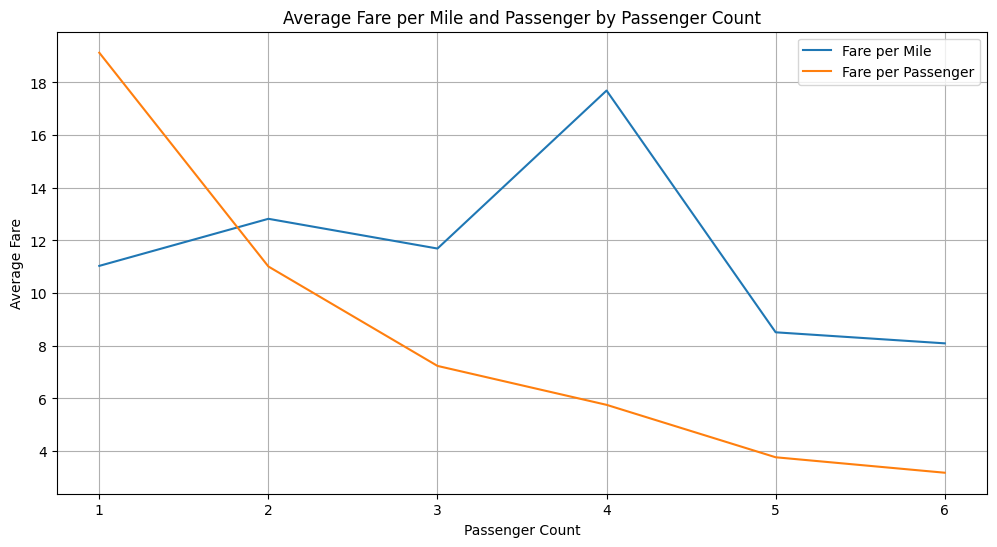

In [56]:
# Analyse the fare per mile per passenger for different passenger counts

# Create a new column for fare per mile
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
# Create a new column for fare per passenger
df['fare_per_passenger'] = df['fare_amount'] / df['passenger_count']
# Group by passenger count and calculate average fare per mile and passenger
passenger_fare = df.groupby('passenger_count').agg({'fare_per_mile': 'mean', 'fare_per_passenger': 'mean'}).reset_index()
# Plot the average fare per mile and passenger
plt.figure(figsize=(12, 6))
plt.plot(passenger_fare['passenger_count'], passenger_fare['fare_per_mile'], label='Fare per Mile')
plt.plot(passenger_fare['passenger_count'], passenger_fare['fare_per_passenger'], label='Fare per Passenger')
plt.title('Average Fare per Mile and Passenger by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare')
plt.legend()
plt.grid()
plt.show()




**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

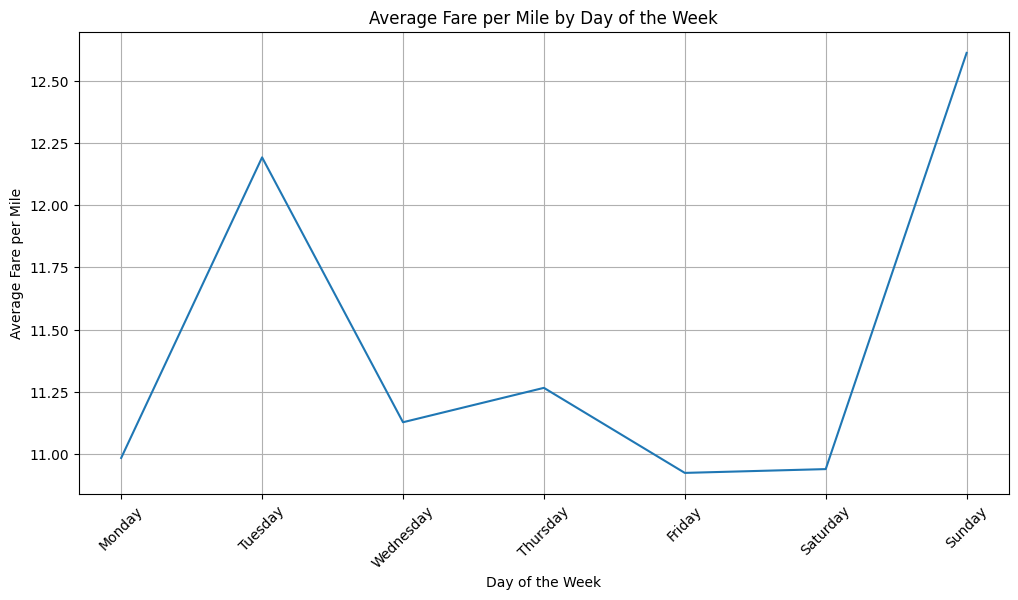

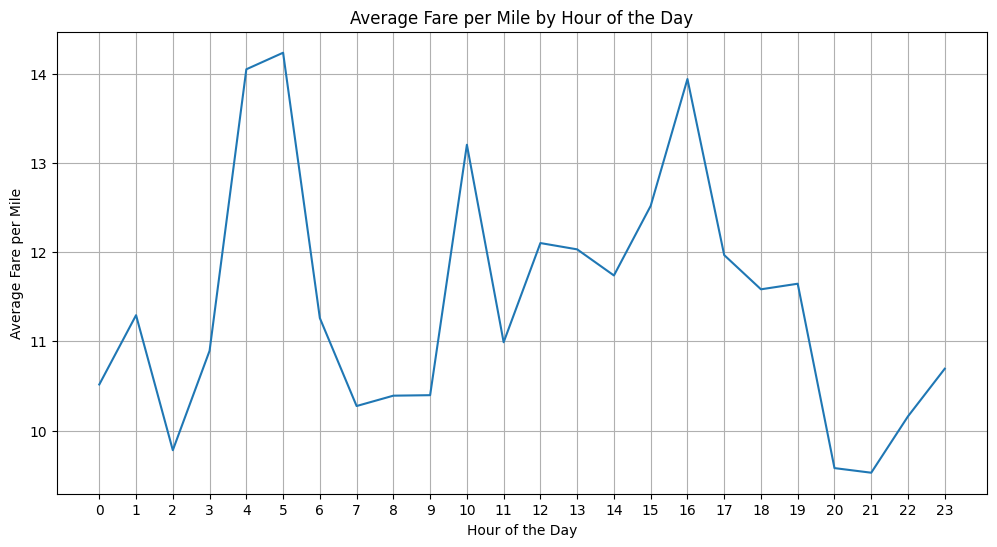

In [57]:
# Compare the average fare per mile for different days and for different times of the day
# Create a new column for fare per mile
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
# Group by day of the week and calculate average fare per mile
weekly_fare = df.groupby('day_of_week')['fare_per_mile'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Plot the average fare per mile by day of the week
plt.figure(figsize=(12, 6))
plt.plot(weekly_fare.index, weekly_fare.values)
plt.title('Average Fare per Mile by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Fare per Mile')
plt.xticks(rotation=45)
plt.grid()
plt.show()
# Group by hour of the day and calculate average fare per mile
hourly_fare = df.groupby('pickup_hour')['fare_per_mile'].mean()
# Plot the average fare per mile by hour of the day
plt.figure(figsize=(12, 6))
plt.plot(hourly_fare.index, hourly_fare.values)
plt.title('Average Fare per Mile by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare per Mile')
plt.xticks(hourly_fare.index)
plt.grid()
plt.show()



**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

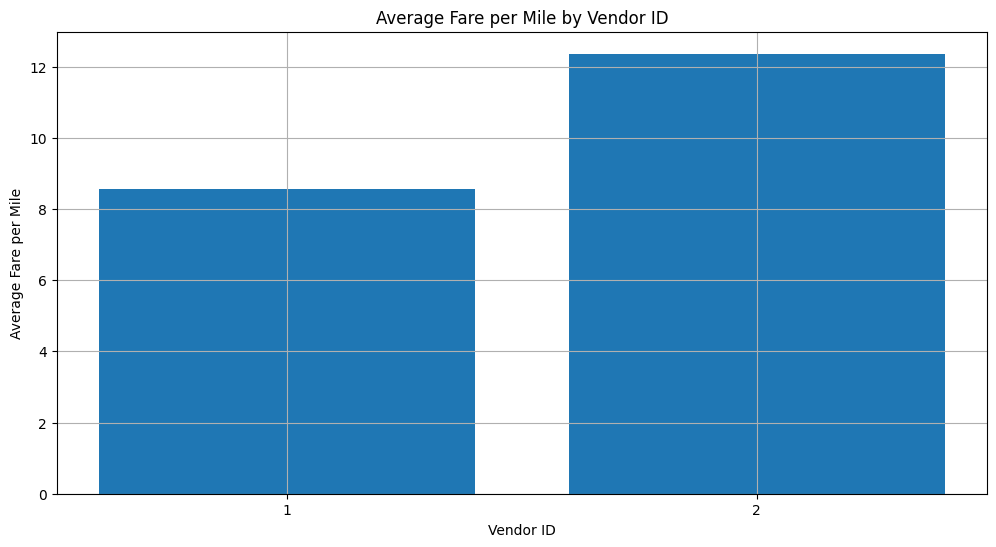

In [58]:
# Compare fare per mile for different vendors
# Group by vendor ID and calculate average fare per mile
vendor_fare = df.groupby('VendorID')['fare_per_mile'].mean()
# Plot the average fare per mile by vendor ID
plt.figure(figsize=(12, 6))
plt.bar(vendor_fare.index, vendor_fare.values)
plt.title('Average Fare per Mile by Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Average Fare per Mile')
plt.xticks(vendor_fare.index)
plt.grid()
plt.show()




**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


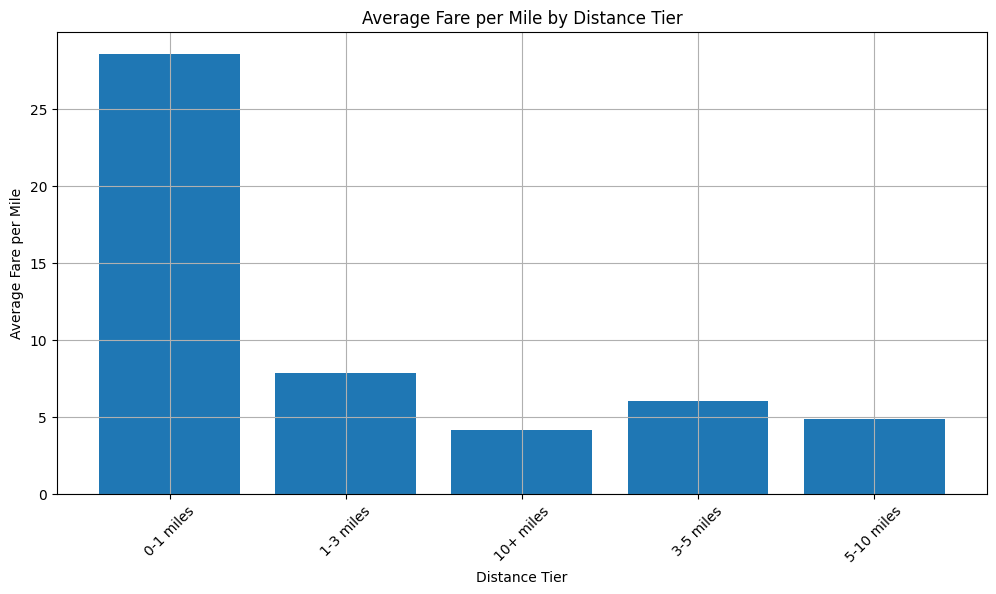

In [59]:
# Defining distance tiers  
def distance_tier(distance):
    if distance < 1:
        return '0-1 miles'
    elif distance < 3:
        return '1-3 miles'
    elif distance < 5:
        return '3-5 miles'
    elif distance < 10:
        return '5-10 miles'
    else:
        return '10+ miles'
# Apply the function to create a new column
df['distance_tier'] = df['trip_distance'].apply(distance_tier)
# Group by distance tier and calculate average fare per mile
distance_fare = df.groupby('distance_tier')['fare_per_mile'].mean().reset_index()
# Plot the average fare per mile by distance tier
plt.figure(figsize=(12, 6))
plt.bar(distance_fare['distance_tier'], distance_fare['fare_per_mile'])
plt.title('Average Fare per Mile by Distance Tier')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare per Mile')
plt.xticks(rotation=45)
plt.grid()
plt.show()




##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

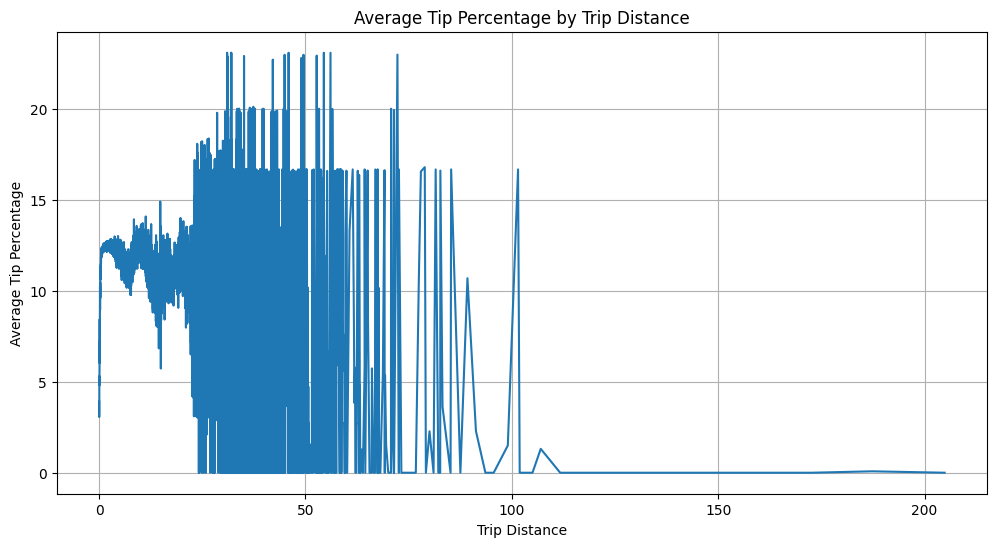

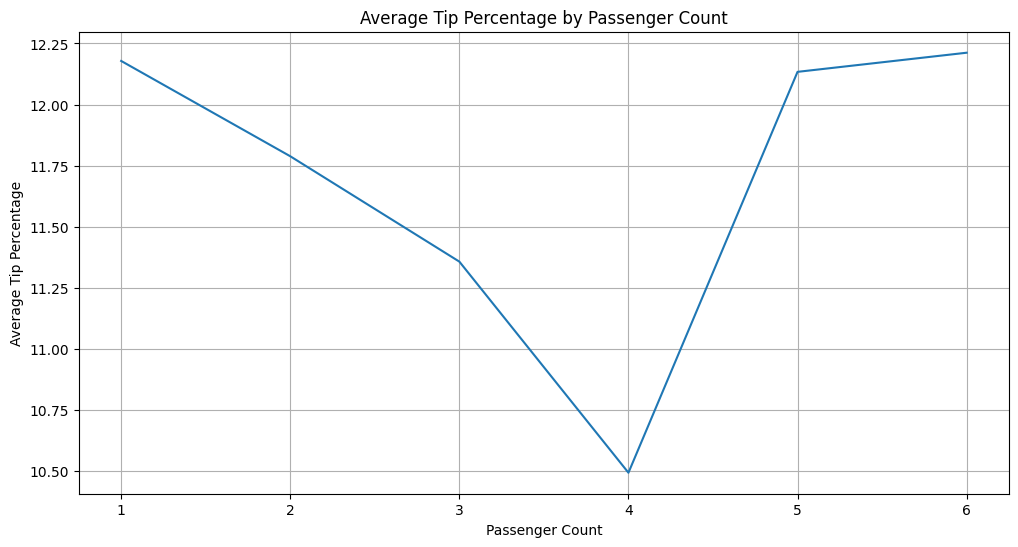

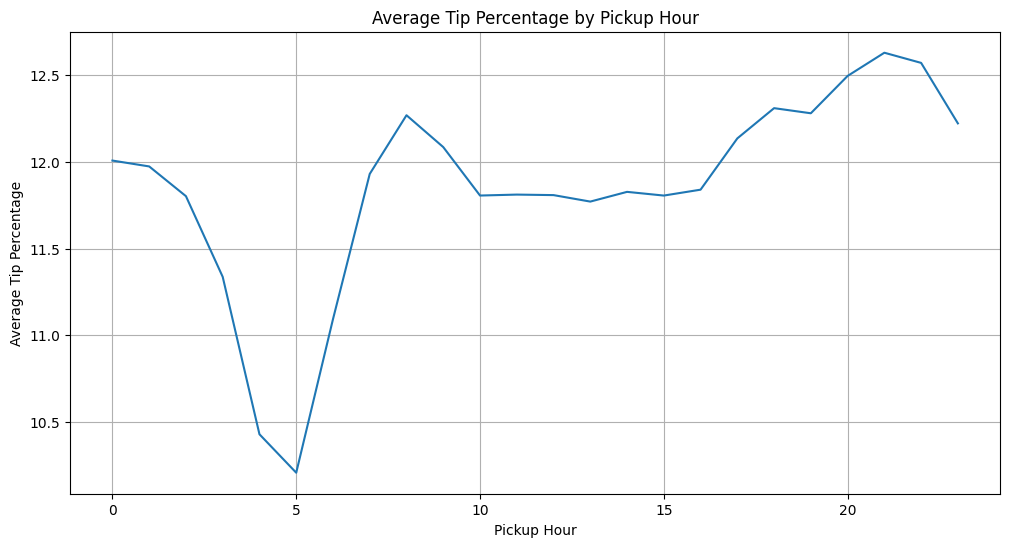

In [60]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
# Create a new column for tip percentage
df['tip_percentage'] = (df['tip_amount'] / df['total_amount']) * 100
# Group by trip distance and calculate average tip percentage
distance_tip = df.groupby('trip_distance')['tip_percentage'].mean().reset_index()
# Plot the average tip percentage by trip distance
plt.figure(figsize=(12, 6))
plt.plot(distance_tip['trip_distance'], distance_tip['tip_percentage'])
plt.title('Average Tip Percentage by Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Average Tip Percentage')
plt.grid()
plt.show()
# Group by passenger count and calculate average tip percentage
passenger_tip = df.groupby('passenger_count')['tip_percentage'].mean().reset_index()
# Plot the average tip percentage by passenger count
plt.figure(figsize=(12, 6))
plt.plot(passenger_tip['passenger_count'], passenger_tip['tip_percentage'])
plt.title('Average Tip Percentage by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Tip Percentage')
plt.grid()
plt.show()
# Group by pickup hour and calculate average tip percentage
pickup_tip = df.groupby('pickup_hour')['tip_percentage'].mean().reset_index()
# Plot the average tip percentage by pickup hour
plt.figure(figsize=(12, 6))
plt.plot(pickup_tip['pickup_hour'], pickup_tip['tip_percentage'])
plt.title('Average Tip Percentage by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Tip Percentage')
plt.grid()
plt.show()



Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

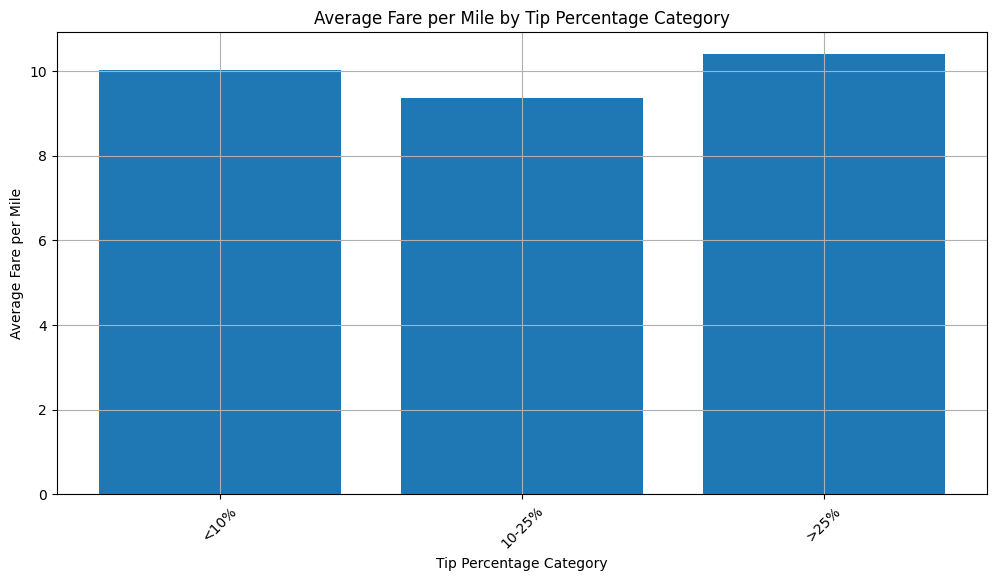

In [61]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
# Create a new column for tip percentage category
df['tip_percentage_category'] = pd.cut(df['tip_percentage'], bins=[0, 10, 25, 100], labels=['<10%', '10-25%', '>25%'])
# Group by tip percentage category and calculate average fare per mile
tip_category_fare = df.groupby('tip_percentage_category')['fare_per_mile'].mean().reset_index()
# Plot the average fare per mile by tip percentage category
plt.figure(figsize=(12, 6))
plt.bar(tip_category_fare['tip_percentage_category'], tip_category_fare['fare_per_mile'])
plt.title('Average Fare per Mile by Tip Percentage Category')
plt.xlabel('Tip Percentage Category')
plt.ylabel('Average Fare per Mile')
plt.xticks(rotation=45)
plt.grid()
plt.show()




**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

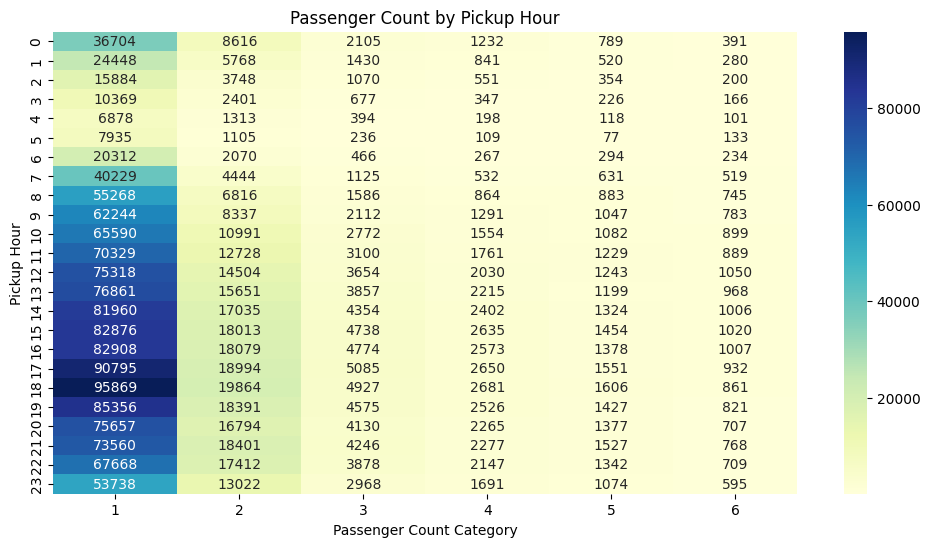

In [62]:
# See how passenger count varies across hours and days
# Create a new column for passenger count category
df['passenger_count_category'] = pd.cut(df['passenger_count'], bins=[0, 1, 2, 3, 4, 5, 6], labels=['1', '2', '3', '4', '5', '6'])
# Group by pickup hour and passenger count category and calculate average passenger count
passenger_hour = df.groupby(['pickup_hour', 'passenger_count_category']).size().reset_index(name='count')
# Pivot the data for heatmap
passenger_hour_pivot = passenger_hour.pivot(index='pickup_hour', columns='passenger_count_category', values='count')
# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(passenger_hour_pivot, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Passenger Count by Pickup Hour')
plt.xlabel('Passenger Count Category')
plt.ylabel('Pickup Hour')
plt.show()




**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

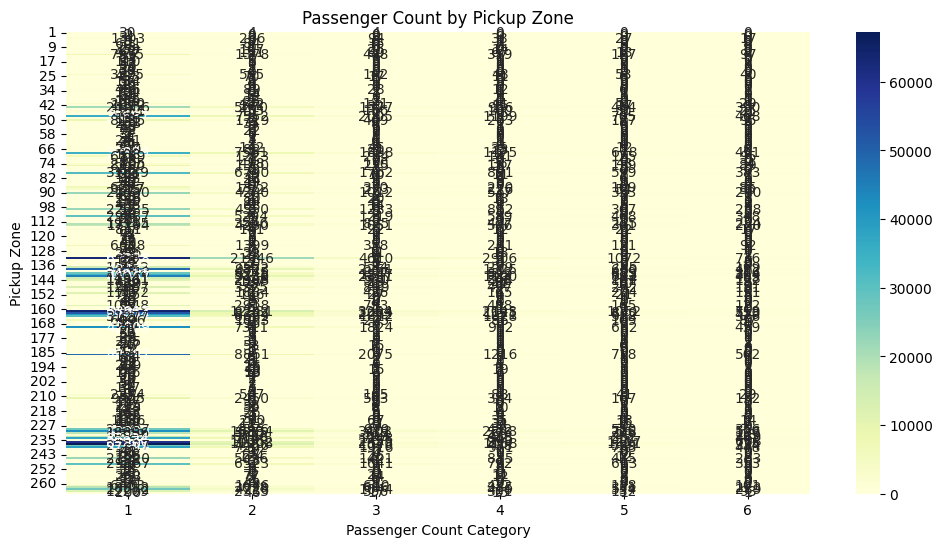

In [63]:
# How does passenger count vary across zones
# Group by pickup zone and passenger count category and calculate average passenger count
passenger_zone = df.groupby(['PULocationID', 'passenger_count_category']).size().reset_index(name='count')
# Pivot the data for heatmap
passenger_zone_pivot = passenger_zone.pivot(index='PULocationID', columns='passenger_count_category', values='count')
# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(passenger_zone_pivot, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Passenger Count by Pickup Zone')
plt.xlabel('Passenger Count Category')
plt.ylabel('Pickup Zone')
plt.show()




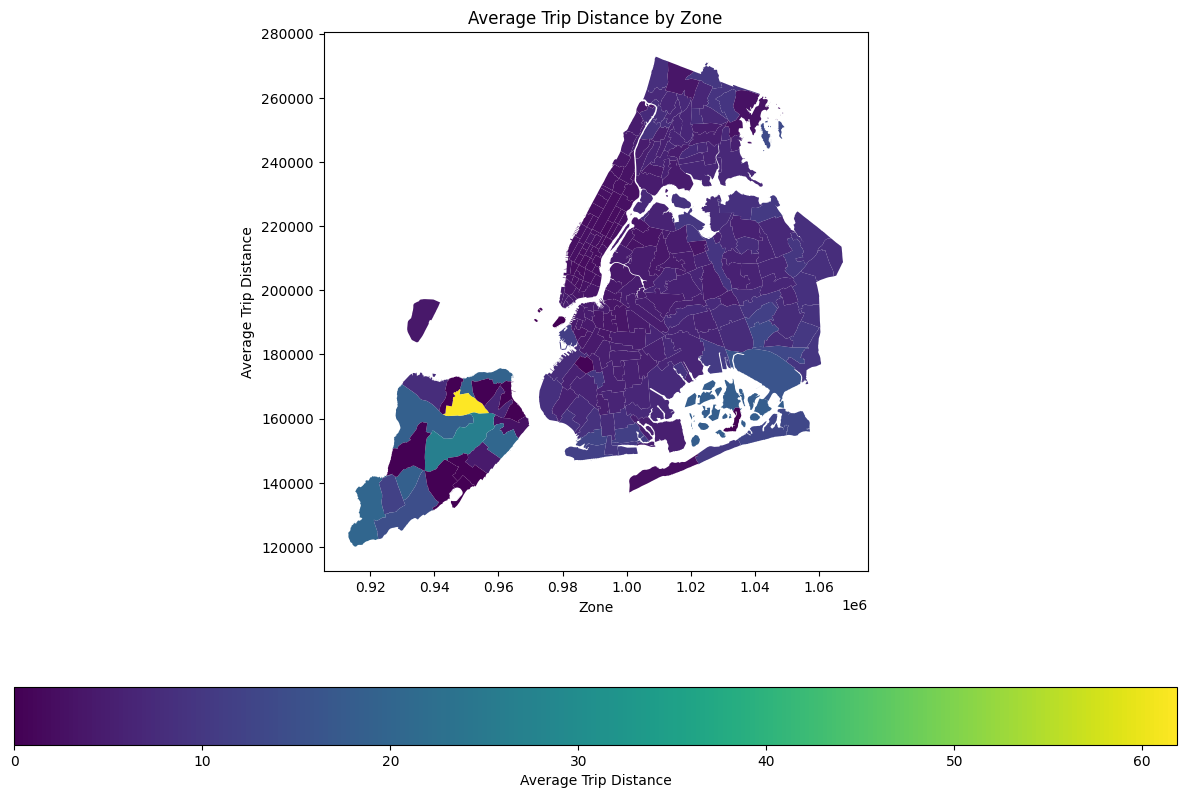

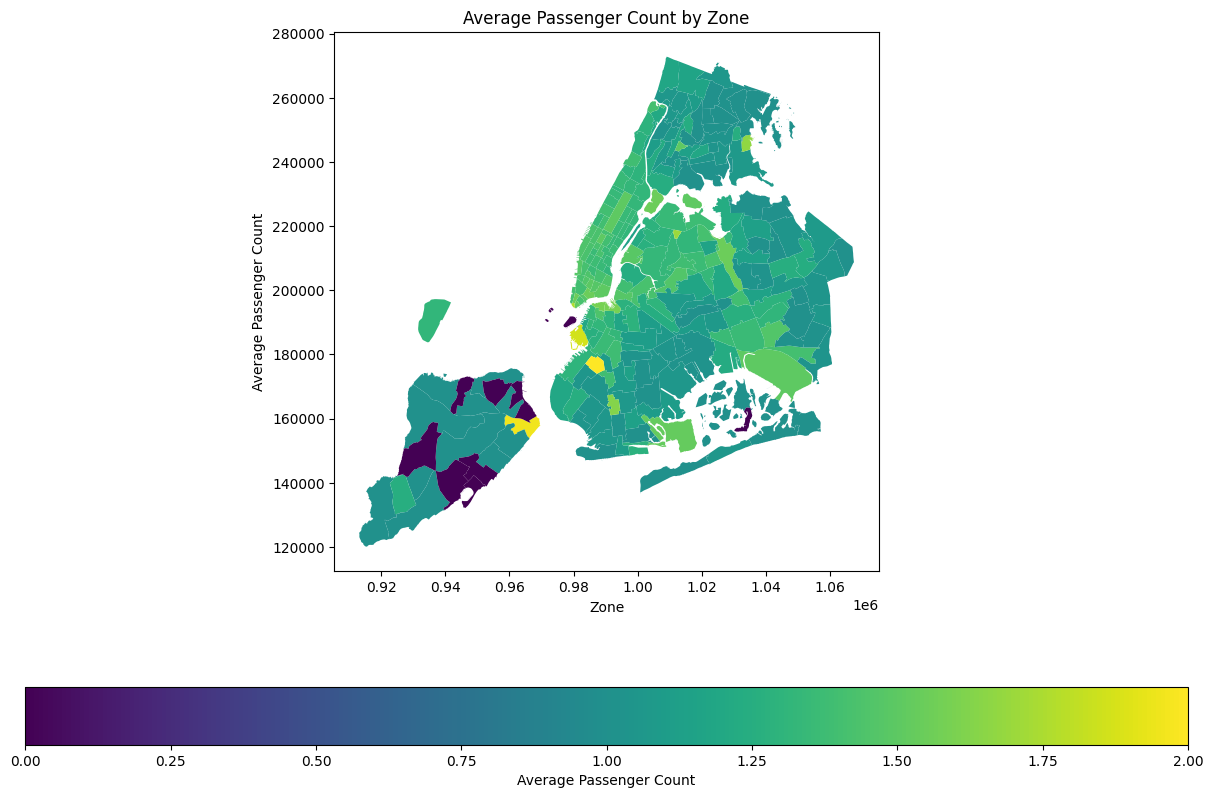

In [64]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame

# Calculate average trip distance per pickup zone
avg_trip_distance = df.groupby('PULocationID')['trip_distance'].mean().reset_index()
zones_with_trips = zones_with_trips.merge(avg_trip_distance, left_on='PULocationID', right_on='PULocationID', how='left', suffixes=('', '_mean'))
zones_with_trips['trip_distance'] = zones_with_trips['trip_distance'].fillna(0)
zones_with_trips = zones_with_trips.rename(columns={'trip_distance': 'avg_trip_distance'})

# Plot the average trip distance by zone
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
zones_with_trips.plot(column='avg_trip_distance', ax=ax, legend=True,
                     legend_kwds={'label': "Average Trip Distance", 'orientation': "horizontal"})
plt.title('Average Trip Distance by Zone')
plt.xlabel('Zone')
plt.ylabel('Average Trip Distance')
plt.show()

# Calculate average passenger count per pickup zone
avg_passenger_count = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
zones_with_trips = zones_with_trips.merge(avg_passenger_count, left_on='PULocationID', right_on='PULocationID', how='left', suffixes=('', '_mean'))
zones_with_trips['passenger_count'] = zones_with_trips['passenger_count'].fillna(0)
zones_with_trips = zones_with_trips.rename(columns={'passenger_count': 'avg_passenger_count'})

# Plot the average passenger count by zone
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
zones_with_trips.plot(column='avg_passenger_count', ax=ax, legend=True,
                     legend_kwds={'label': "Average Passenger Count", 'orientation': "horizontal"})
plt.title('Average Passenger Count by Zone')
plt.xlabel('Zone')
plt.ylabel('Average Passenger Count')
plt.show()



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

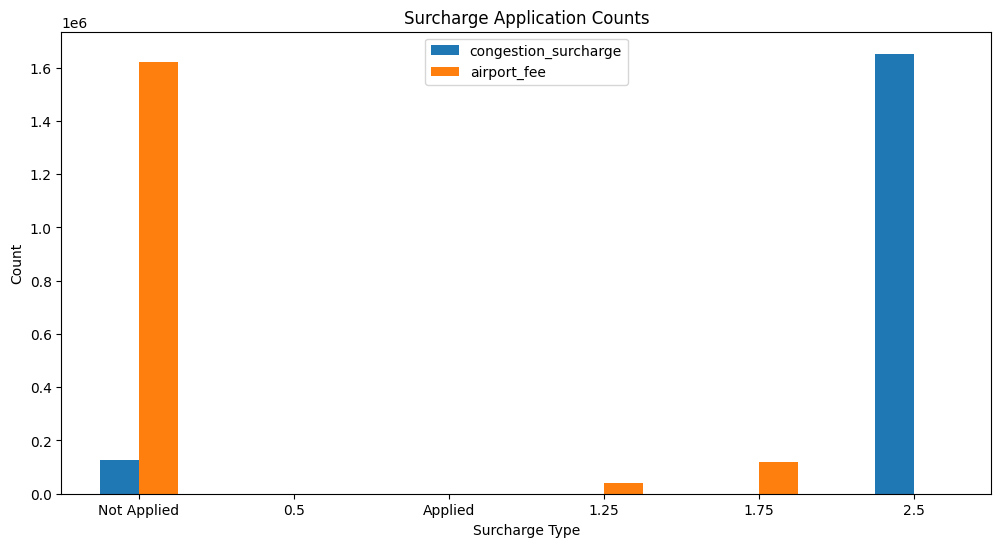

In [65]:
# How often is each surcharge applied?
surcharge_counts = df[['congestion_surcharge', 'airport_fee']].apply(pd.Series.value_counts)
surcharge_counts = surcharge_counts.fillna(0)
surcharge_counts = surcharge_counts.astype(int)
surcharge_counts = surcharge_counts.rename(index={0: 'Not Applied', 1: 'Applied'})
surcharge_counts.plot(kind='bar', figsize=(12,6))
plt.title('Surcharge Application Counts')
plt.xlabel('Surcharge Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

1. **Align Supply with Peak Demand Hours:**  
    The busiest hours are between 15:00 and 19:00, with over 1.1 million trips each hour (scaled). Increase taxi availability and dispatching during these hours to reduce passenger wait times and maximize revenue.

2. **Target High-Demand Zones:**  
    Zones such as JFK Airport, Midtown Center, and Upper East Side consistently have the highest pickup counts. Prioritize dispatching taxis to these zones, especially during peak hours, to capture more trips.

3. **Address Operational Bottlenecks:**  
    The slowest average speeds occur around 15:00 (9.93 mph) and on Thursdays (10.86 mph). Consider dynamic routing or alternative paths during these times to avoid congestion and improve trip efficiency.

4. **Nighttime Optimization:**  
    Although nighttime (11PM–5AM) accounts for only ~12% of revenue, certain zones (e.g., JFK Airport, zone 264) remain active. Maintain a minimum fleet in these areas to serve late-night travelers and ensure safety.

5. **Leverage Data for Dynamic Dispatch:**  
    Use real-time and historical data to predict demand surges by hour, day, and zone. Implement automated dispatching systems that proactively reposition taxis based on these patterns.

6. **Monitor and Adjust for Special Events:**  
    High-traffic routes and zones may shift during events or holidays. Continuously monitor demand and adjust routing/dispatching strategies accordingly.

7. **Encourage Efficient Routing:**  
    Provide drivers with tools or incentives to avoid known bottlenecks and optimize routes, especially during slow hours and in congested zones.

By implementing these recommendations, taxi operations can better match supply with demand, reduce inefficiencies, and improve both driver and passenger satisfaction.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

Recommendations:

1 - Position more cabs in Midtown, Upper East Side, and JFK/LaGuardia during evening rush hours and weekend nights.

2 - Increase cab availability in zones with high night activity (e.g., zone 264, 79, 249).

3 - Adjust supply dynamically based on hourly demand, especially for hours 15-19.

4- On weekends, focus on entertainment and nightlife zones.

5 - Monitor zones with high multi-passenger pickups for larger vehicles.

6 - Use historical speed data to avoid slowest routes during peak congestion.

These strategies help maximize coverage, reduce passenger wait times, and optimize driver earnings.


<!-- ## Strategic suggestions for cab positioning based on trip trends: -->
<!--  -->
<!-- 1 - ** Position more cabs in Midtown, Upper East Side, and JFK/LaGuardia during evening rush hours and weekend nights. -->
<!-- 2 - ** Increase cab availability in zones with high night activity (e.g., zone 264, 79, 249). -->
<!-- 3 - ** Adjust supply dynamically based on hourly demand, especially for hours 15-19. -->
<!-- 4- ** On weekends, focus on entertainment and nightlife zones. -->
<!-- 5 - ** Monitor zones with high multi-passenger pickups for larger vehicles. -->
<!-- 6 - ** Use historical speed data to avoid slowest routes during peak congestion. -->
<!--  -->
<!-- These strategies help maximize coverage, reduce passenger wait times, and optimize driver earnings. -->



**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

#### Data-driven pricing strategy recommendations:

##### ### # 1. Dynamic Pricing by Time and Day
# Increase fare per mile during peak hours (15-19) and on high-demand days (Friday, Sunday), as weekly_fare and hourly_fare show higher willingness to pay.


# 2. Distance-Based Tiered Pricing
# Use distance tiers to set competitive rates: keep short-trip fares competitive, but increase per-mile rates for longer trips where demand is less price-sensitive.


# 3. Vendor Benchmarking
# Vendor 2 charges higher per mile than Vendor 1. Consider aligning rates for short trips, but offer discounts or loyalty incentives for frequent riders to retain market share.

# 4. Nighttime Surcharge
# Nighttime trips (11PM–5AM) account for ~12% of revenue. Consider a modest nighttime surcharge to offset lower demand and higher operational costs, but keep it below competitors to attract more riders.

# 5. Group/Shared Ride Discounts
# For higher passenger counts, fare per mile per passenger drops. Promote shared rides with group discounts to maximize occupancy and revenue per trip.

# 6. Transparent Surcharges
# Clearly communicate congestion and airport surcharges, as these are frequently applied. Consider bundling or capping surcharges to improve customer satisfaction.

# 7. Monitor and Adjust
# Regularly review fare competitiveness using vendor_fare and adjust rates based on demand elasticity, competitor pricing, and customer feedback.


# Recommendations
# Implement dynamic pricing for peak hours and high-demand days.
# Use distance-based tiered pricing to maximize revenue from longer trips.
# Benchmark and adjust rates to remain competitive with other vendors.
# Introduce a moderate nighttime surcharge to cover operational costs.
# Offer group ride discounts to encourage higher occupancy.
# Cap or bundle surcharges for transparency and customer trust.
# Continuously monitor fare competitiveness and adjust as needed.